In [1]:
import numpy as np #for our Qtable
import gym #for our cartpole Environment
import random #to generate random numbers
import pandas
from collections import deque

#neural network packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D,Flatten
from tensorflow.python.keras import utils

#code for rendering gui
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install pyglet==1.4.0
!apt-get install x11-utils

import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1800, 1800))
display.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 13 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 1s (487 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 146374 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 13 not upgraded.
Need to get 784 kB of 

In [2]:
class DQN():
  def __init__(self,state_space,action_space,weights_file):
    self.learning_rate = 0.2          # Learning rate
    self.gamma = 0.95                 # Discounting rate

    # Exploration parameters
    self.epsilon = 0.99                 # Exploration rate
    self.max_epsilon = 0.99             # Exploration probability at start
    self.min_epsilon = 0.1            # Minimum exploration probability 
    self.decay_rate = 0.995            # Exponential decay rate for exploration prob

    #neural network parameters
    self.state_space = state_space
    self.action_space=action_space
    self.batch_size =16
    self.input_size = state_space.shape
    self.output_size = action_space.n
    self.model = self.buildQNetwork()
    self.target = self.buildQNetwork()
    self.memory = deque(maxlen=2000)  #doubel ended queue for storing the transitions
    self.target_update_interval = 4
    self.weights_file = weights_file

  def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
  
  def updateTarget(self,steps):
    if steps >= self.batch_size and steps % self.target_update_interval == 0:
      self.target.set_weights(self.model.get_weights())
      print("target updated")

  def load_weights(self):
    self.model.load_weights(self.weights_file)

  def save_weights(self):
    print("Saving wights to file")
    self.model.save_weights(self.weights_file)

  
  def buildQNetwork(self):
    model = Sequential()
    model.add(Conv2D(32, (3,3),input_shape=self.input_size, activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(64, (3,3),activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))#fully connected
    model.add(Dense(10, activation='relu'))
    model.add(Dense(self.output_size))
    model.compile(loss='mse', optimizer='adam')
    return model

  def predict(self, state, isTarget):
    state = np.reshape(state, (1,) + state.shape)
    if isTarget:
      result= self.target.predict(state)
    else:
      result= self.model.predict(state)
    #print(result.shape)
    return result

    
  def chooseAction(self,state,isEpsilonGreedy):
    exp_exp_tradeoff = random.uniform(0, 1)
    
    if exp_exp_tradeoff > self.epsilon or not isEpsilonGreedy:
        qval = self.predict(state,False)[0]
        maxqval = max(qval)
        action= np.where(qval == maxqval)[0][0]
        print("Qaction",action)
       
    else:
        action = self.action_space.sample()
        print("random action",action)
    return action

  def updateEpsilon(self,steps):
    self.epsilon *= self.decay_rate
    if(self.epsilon < self.min_epsilon):
      self.epsilon = self.min_epsilon
    #print(self.epsilon)
    #self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon)*np.exp(-self.decay_rate*steps) 

  def calcualteTargetValue(self,state, action, reward, next_state, isDone):
    
    
    qnext = self.predict(next_state, True)
    maxqval = max(qnext[0])
   
    if done:
      target_value = reward
    else:
      target_value = reward + self.gamma *maxqval 

    return target_value

  def train(self):
    X_train = np.zeros((self.batch_size,210, 160, 3))
    Y_train = np.zeros((self.batch_size, self.output_size))
    loss =0
    if len(self.memory)<self.batch_size:
      print("memory insufficient for training")
      return loss
    mini_batch = random.sample(self.memory, self.batch_size)
    for index_rep in range(self.batch_size):
      state,action,reward,next_state,isDone = mini_batch[index_rep]
      X_train[index_rep] = state
      Y_train[index_rep][action] = self.calcualteTargetValue(state,action,reward,next_state,isDone)
    #print("train shape",X_train.shape,"yshape",Y_train.shape)
    loss = self.model.train_on_batch(X_train, Y_train)
    
    return loss


env = gym.make("Alien-v0")

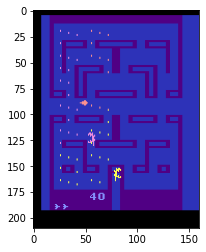

random action 17


KeyboardInterrupt: ignored

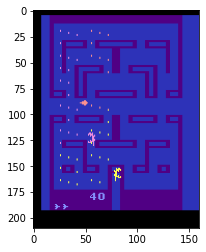

In [3]:
#print(env.observation_space,env.observation_space.shape)
#print(env.action_space)
rewards = []
weights_file = 'dqn.h5'

learner = DQN(env.observation_space,env.action_space,weights_file)
total_episodes = 2      # Total episodes
max_steps = 100               # Max steps per episode
total_steps=0
for episode in range(total_episodes): 
    # Reset the environment
    state = env.reset()


    step = 0
    done = False
    total_rewards = 0
    loss =0
    prev_screen = env.render(mode='rgb_array')
    plt.imshow(prev_screen)
    for step in range(max_steps): 
      screen = env.render(mode='rgb_array')
      plt.imshow(screen)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())
    
      
      action = learner.chooseAction(state,True)
      # Take the action (a) and observe the outcome state(s') and reward (r)
      new_state, reward, done, info = env.step(action)
     

      learner.memorize(state,action,reward, new_state,done)
      #Calcualte the loss and train (optimize) the Q-network
      
      loss +=learner.train()
      learner.updateTarget(total_steps)

      total_rewards += reward
      total_steps += 1
      # Our new state is state
      state = new_state
      
      # If done (if we're dead) : finish episode
      if done == True:
        print("game over")
        break
  # Reduce epsilon (because we need less and less exploration)
      learner.updateEpsilon(total_steps)
    print("loss=",loss)
    rewards.append(total_rewards)
    ipythondisplay.clear_output(wait=True)
print(rewards, max(rewards))
print ("Score over time: " +  str(sum(rewards)/total_episodes))
learner.save_weights()

env.reset()

KeyboardInterrupt: ignored

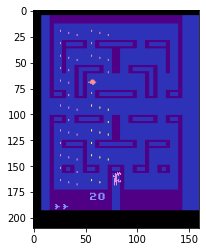

In [4]:
for episode in range(5):
    state = env.reset()
   
    
    step = 0
    done = False
    print("****************************************************")
    print("EPISODE ", episode)
    prev_screen = env.render(mode='rgb_array')
    plt.imshow(prev_screen)
    for step in range(max_steps):
        
        # Take the action (index) that have the maximum expected future reward given that state
        action = learner.chooseAction(state,False)
        
        new_state, reward, done, info = env.step(action)
        
        screen = env.render(mode='rgb_array')
        plt.imshow(screen)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())
        if done:
          break
        state = new_state
    ipythondisplay.clear_output(wait=True)
env.close()